In [95]:
from datasets import load_dataset
from transformers import DistilBertTokenizer, AutoModel
import matplotlib.pyplot as plt
from utils import label_int2str, tokenize, extract_hidden_states
import torch
import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [2]:
banking = load_dataset("banking77")

/home/fabio/.cache/huggingface/modules/datasets_modules/datasets/banking77/9898c11f6afa9521953d2ef205667b527bad14ef9cab445d470f16240c8c8ec4/banking77.py:59: FutureWarning: Dataset 'banking77' is deprecated and will be deleted. Use 'PolyAI/banking77' instead.
  warnings.warn(
Found cached dataset banking77 (/home/fabio/.cache/huggingface/datasets/banking77/default/1.1.0/9898c11f6afa9521953d2ef205667b527bad14ef9cab445d470f16240c8c8ec4)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1124.63it/s]


In [3]:
banking.set_format(type="pandas")
train_df = banking["train"][:]
train_df.head()

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


In [4]:
train_df["label_name"] = train_df["label"].apply(
    label_int2str, args=(banking["train"],)
)
train_df.head()

,text,label,label_name
0,I am still waiting on my card?,11,card_arrival
1,What can I do if my card still hasn't arrived ...,11,card_arrival
2,I have been waiting over a week. Is the card s...,11,card_arrival
3,Can I track my card while it is in the process...,11,card_arrival
4,"How do I know if I will get my card, or if it ...",11,card_arrival


In [5]:
banking["train"].features["label"].num_classes

77

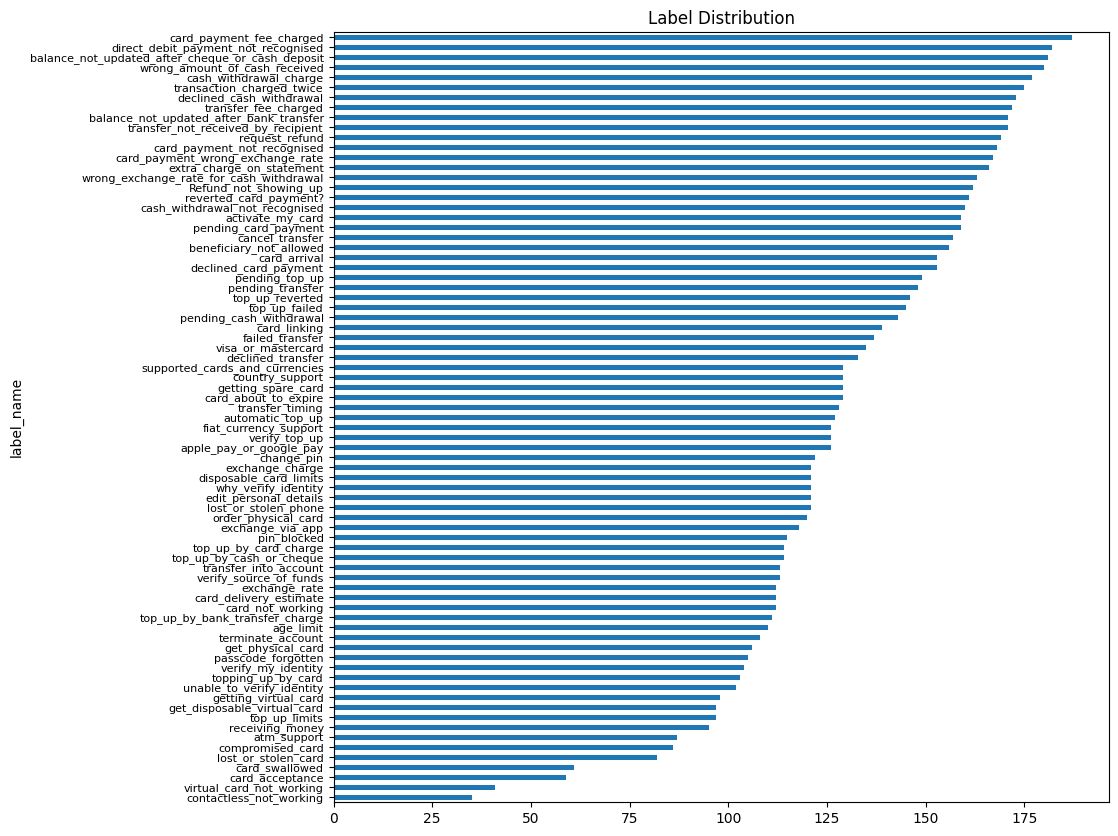

In [6]:
fig = plt.figure(figsize=(10, 10))
train_df["label_name"].value_counts(ascending=True).plot(kind="barh")
# lower font size for y axis tick labels
plt.yticks(fontsize=8)
plt.title("Label Distribution")
plt.show()

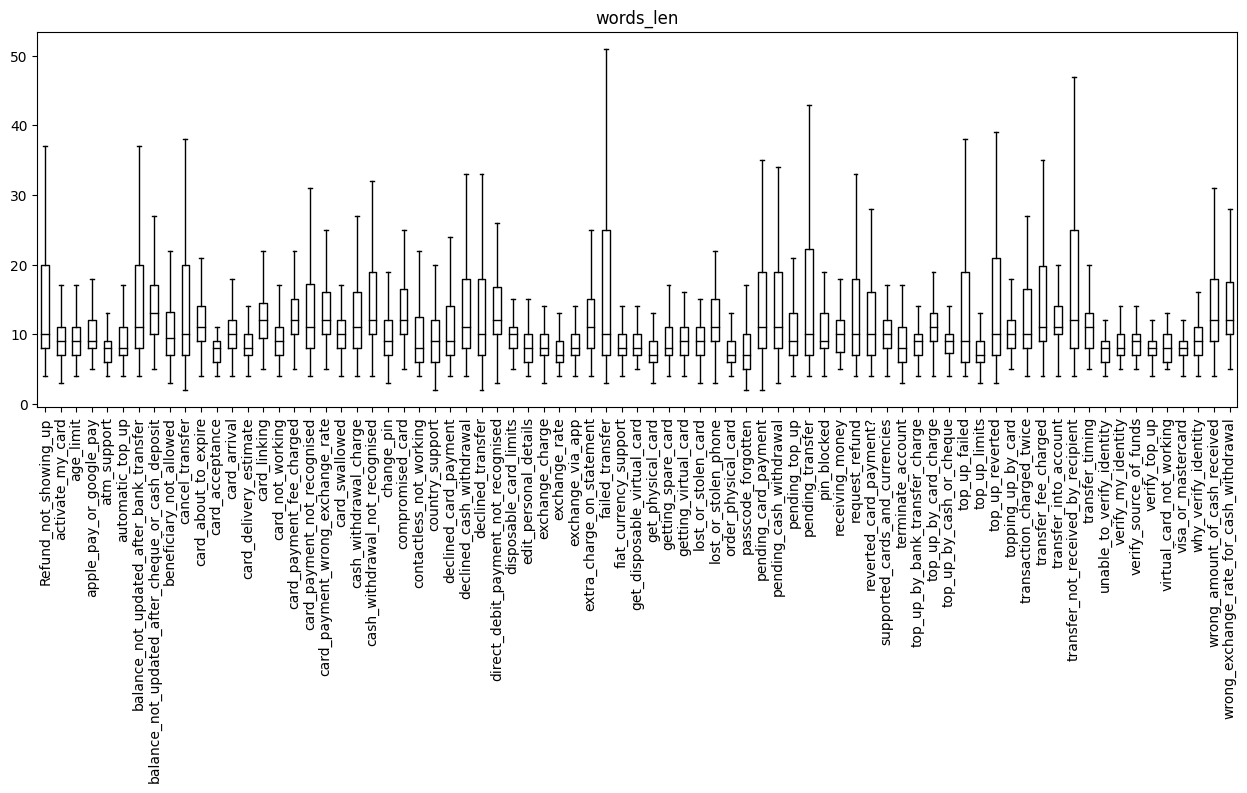

In [7]:
train_df["words_len"] = train_df["text"].str.split().apply(len)
train_df.boxplot(
    by="label_name",
    column="words_len",
    grid=False,
    figsize=(15, 5),
    showfliers=False,
    color="black",
)
plt.suptitle("")
plt.xlabel("")
# 90 rotation for x axis tick labels
plt.xticks(rotation=90)
plt.show()

In [8]:
model_ckpt = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [9]:
text = "I want to open a savings account."
token_text = tokenizer(text)
tokens = tokenizer.convert_ids_to_tokens(token_text.input_ids)
print(token_text)
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))

{'input_ids': [101, 1045, 2215, 2000, 2330, 1037, 10995, 4070, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'i', 'want', 'to', 'open', 'a', 'savings', 'account', '.', '[SEP]']
[CLS] i want to open a savings account . [SEP]


In [10]:
banking.reset_format()
tokenize(banking["train"][:2], tokenizer)

{'input_ids': [[101, 1045, 2572, 2145, 3403, 2006, 2026, 4003, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2054, 2064, 1045, 2079, 2065, 2026, 4003, 2145, 8440, 1005, 1056, 3369, 2044, 1016, 3134, 1029, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [11]:
encoded_banking = banking.map(
    tokenize, batched=True, batch_size=None, fn_kwargs={"tokenizer": tokenizer}
)
print(encoded_banking.column_names)

Loading cached processed dataset at /home/fabio/.cache/huggingface/datasets/banking77/default/1.1.0/9898c11f6afa9521953d2ef205667b527bad14ef9cab445d470f16240c8c8ec4/cache-22d28ee6567d1b1c.arrow
Loading cached processed dataset at /home/fabio/.cache/huggingface/datasets/banking77/default/1.1.0/9898c11f6afa9521953d2ef205667b527bad14ef9cab445d470f16240c8c8ec4/cache-0920acca6d34e15e.arrow


{'train': ['text', 'label', 'input_ids', 'attention_mask'], 'test': ['text', 'label', 'input_ids', 'attention_mask']}


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
inputs = tokenizer(text, return_tensors='pt')
print(inputs['input_ids'].size())
print(inputs)

torch.Size([1, 10])
{'input_ids': tensor([[  101,  1045,  2215,  2000,  2330,  1037, 10995,  4070,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


This is the outputs when the `text` is used as input:

In [14]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[ 0.1241, -0.0199,  0.1110,  ..., -0.0197,  0.2407,  0.2950],
         [ 0.5138,  0.0545, -0.0756,  ...,  0.0831,  0.4290,  0.3779],
         [ 0.4962,  0.1025,  0.4482,  ..., -0.3452,  0.0827,  0.2016],
         ...,
         [ 0.3162, -0.3501,  0.2001,  ..., -0.2099, -0.2408,  0.5594],
         [ 0.7171, -0.0106, -0.5186,  ...,  0.2094, -0.4327, -0.4900],
         [ 0.4394,  0.1482,  0.2622,  ...,  0.2171, -0.0182, -0.1042]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [15]:
outputs.last_hidden_state.size()

torch.Size([1, 10, 768])

In [16]:
encoded_banking.set_format('torch', columns = ['input_ids', 'attention_mask', 'label'])

In [17]:
encoded_hidden = encoded_banking.map(extract_hidden_states, batched=True, fn_kwargs={'model': model, 'tokenizer': tokenizer, 'device': device})

Loading cached processed dataset at /home/fabio/.cache/huggingface/datasets/banking77/default/1.1.0/9898c11f6afa9521953d2ef205667b527bad14ef9cab445d470f16240c8c8ec4/cache-c6bfa85878135159.arrow
Loading cached processed dataset at /home/fabio/.cache/huggingface/datasets/banking77/default/1.1.0/9898c11f6afa9521953d2ef205667b527bad14ef9cab445d470f16240c8c8ec4/cache-6b6875ecdbfd8942.arrow


In [18]:
encoded_hidden.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
 'test': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']}

In [19]:
x_train = np.array(encoded_hidden['train']['hidden_state'])
y_train = np.array(encoded_hidden['train']['label'])

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(8002, 768) (8002,)
(2001, 768) (2001,)


In [40]:
x_scaled = MinMaxScaler().fit_transform(x_train)
mapper = UMAP(n_components=2, metric='cosine').fit(x_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,1.567038,-1.493759,16
1,6.398808,3.034412,14
2,0.961126,4.631988,24
3,8.073559,1.922228,20
4,4.275685,1.268596,66


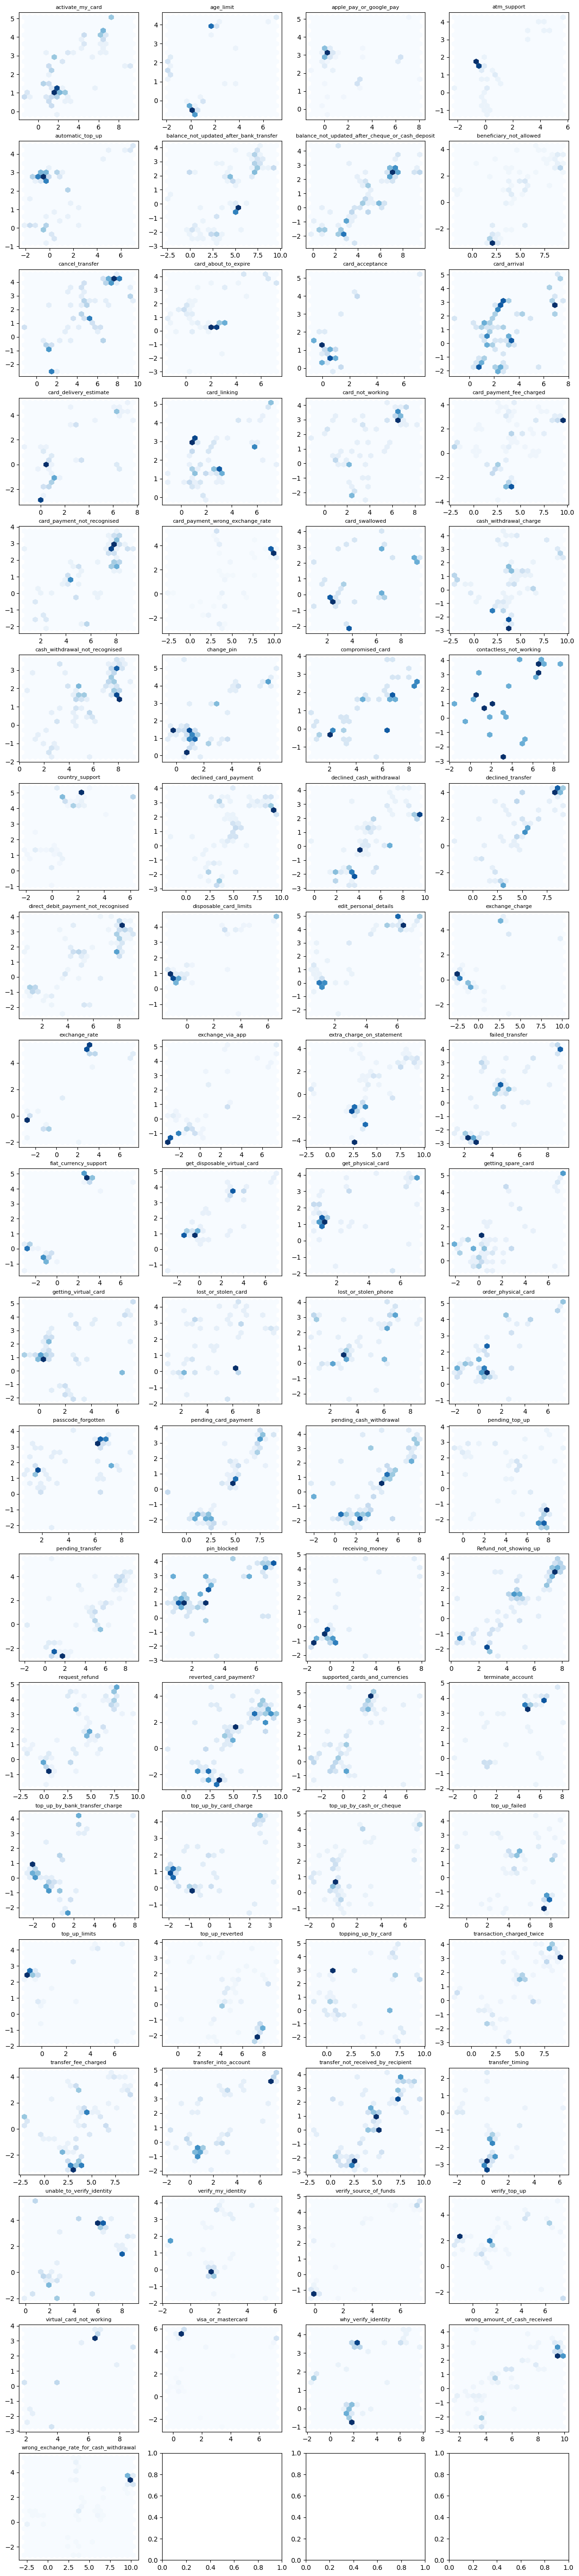

In [79]:
fig, axes = plt.subplots(banking["train"].features["label"].num_classes // 4 + 1, 4, figsize=(15, 70))
axes = axes.flatten()
labels = banking['train'].features['label'].names

for i, label in enumerate(labels):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap='Blues', gridsize=20, linewidths=(0,))
    axes[i].set_title(label, fontsize=8)

In [102]:
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(x_train, y_train)
lr_clf.score(x_valid, y_valid)

0.8390804597701149